# DocMatchNet-Original Training
==============================
Single-stage training with score-space prediction

GPU Required: T4 or P100  
Runtime: ~2-3 hours total

In [1]:
# ============================================================
# CELL 1: Setup
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import numpy as np
from tqdm import tqdm
import json
import os

# Set seed per run: 42, 123, 456
SEED = 456

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Output path per seed
RUN_DIR = f'/kaggle/working/results/original/seed_{SEED}'
os.makedirs(RUN_DIR, exist_ok=True)
print(f"Run dir: {RUN_DIR}")


Using device: cuda
GPU: Tesla T4
Memory: 15.6 GB
Run dir: /kaggle/working/results/original/seed_456


In [2]:
# ============================================================
# CELL 2: Load Data
# ============================================================
# Update this if your Kaggle dataset slug/path differs.
DATA_DIR = '/kaggle/input/docmatchnet-jepa-data/data'

# PyTorch 2.6+: use weights_only=False for non-state_dict data files.
doctor_embeddings = torch.load(f'{DATA_DIR}/doctor_embeddings.pt', weights_only=False)
case_embeddings = torch.load(f'{DATA_DIR}/case_embeddings.pt', weights_only=False)
clinical_features = torch.load(f'{DATA_DIR}/clinical_features.pt', weights_only=False)
pastwork_features = torch.load(f'{DATA_DIR}/pastwork_features.pt', weights_only=False)
logistics_features = torch.load(f'{DATA_DIR}/logistics_features.pt', weights_only=False)
trust_features = torch.load(f'{DATA_DIR}/trust_features.pt', weights_only=False)
context_features = torch.load(f'{DATA_DIR}/context_features.pt', weights_only=False)
relevance_labels = torch.load(f'{DATA_DIR}/relevance_labels.pt', weights_only=False)
doctor_indices = torch.load(f'{DATA_DIR}/doctor_indices.pt', weights_only=False)
case_metadata = torch.load(f'{DATA_DIR}/case_metadata.pt', weights_only=False)
splits = torch.load(f'{DATA_DIR}/splits.pt', weights_only=False)

print('Loaded data:')
print(f'  Doctor embeddings: {doctor_embeddings.shape}')
print(f'  Case embeddings: {case_embeddings.shape}')
print(f'  Clinical features: {clinical_features.shape}')
print(f"  Train/Val/Test: {len(splits['train'])}/{len(splits['val'])}/{len(splits['test'])}")


Loaded data:
  Doctor embeddings: torch.Size([500, 384])
  Case embeddings: torch.Size([15000, 384])
  Clinical features: torch.Size([15000, 100, 4])
  Train/Val/Test: 10500/2250/2250


In [3]:
# ============================================================
# CELL 3: Dataset Classes
# ============================================================
class DocMatchDatasetOriginal(Dataset):
    """Dataset for pairwise score-space training."""

    def __init__(self, indices, case_emb, doc_emb, doc_indices,
                 clinical, pastwork, logistics, trust, context,
                 relevance, metadata):
        self.indices = indices
        self.case_emb = case_emb
        self.doc_emb = doc_emb
        self.doc_indices = doc_indices
        self.clinical = clinical
        self.pastwork = pastwork
        self.logistics = logistics
        self.trust = trust
        self.context = context
        self.relevance = relevance
        self.metadata = metadata

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        case_idx = self.indices[idx]
        rel = self.relevance[case_idx]

        pos_mask = rel >= 3
        if pos_mask.sum() == 0:
            pos_mask = rel == rel.max()

        neg_mask = rel <= 1
        if neg_mask.sum() == 0:
            neg_mask = rel < rel.max()

        pos_local = torch.where(pos_mask)[0]
        neg_local = torch.where(neg_mask)[0]

        pos_idx = pos_local[torch.randint(len(pos_local), (1,))].item()
        neg_idx = neg_local[torch.randint(len(neg_local), (1,))].item()

        pos_doc_global = self.doc_indices[case_idx, pos_idx]
        neg_doc_global = self.doc_indices[case_idx, neg_idx]

        return {
            'case_embedding': self.case_emb[case_idx],
            'pos_doctor_embedding': self.doc_emb[pos_doc_global],
            'neg_doctor_embedding': self.doc_emb[neg_doc_global],
            'pos_clinical': self.clinical[case_idx, pos_idx],
            'neg_clinical': self.clinical[case_idx, neg_idx],
            'pos_pastwork': self.pastwork[case_idx, pos_idx],
            'neg_pastwork': self.pastwork[case_idx, neg_idx],
            'pos_logistics': self.logistics[case_idx, pos_idx],
            'neg_logistics': self.logistics[case_idx, neg_idx],
            'pos_trust': self.trust[case_idx, pos_idx],
            'neg_trust': self.trust[case_idx, neg_idx],
            'context': self.context[case_idx],
            'pos_label': torch.tensor(1.0, dtype=torch.float32),
            'neg_label': torch.tensor(0.0, dtype=torch.float32),
            'context_category': self.metadata['context_category'][case_idx]
        }


class DocMatchDatasetEval(Dataset):
    """Dataset for listwise evaluation."""

    def __init__(self, indices, case_emb, doc_emb, doc_indices,
                 clinical, pastwork, logistics, trust, context,
                 relevance, metadata):
        self.indices = indices
        self.case_emb = case_emb
        self.doc_emb = doc_emb
        self.doc_indices = doc_indices
        self.clinical = clinical
        self.pastwork = pastwork
        self.logistics = logistics
        self.trust = trust
        self.context = context
        self.relevance = relevance
        self.metadata = metadata

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        case_idx = self.indices[idx]
        doc_global_indices = self.doc_indices[case_idx]

        return {
            'case_embedding': self.case_emb[case_idx],
            'doctor_embeddings': self.doc_emb[doc_global_indices],
            'clinical': self.clinical[case_idx],
            'pastwork': self.pastwork[case_idx],
            'logistics': self.logistics[case_idx],
            'trust': self.trust[case_idx],
            'context': self.context[case_idx],
            'relevance': self.relevance[case_idx],
            'context_category': self.metadata['context_category'][case_idx]
        }

train_ds = DocMatchDatasetOriginal(
    splits['train'], case_embeddings, doctor_embeddings, doctor_indices,
    clinical_features, pastwork_features, logistics_features, trust_features,
    context_features, relevance_labels, case_metadata
)

val_ds = DocMatchDatasetEval(
    splits['val'], case_embeddings, doctor_embeddings, doctor_indices,
    clinical_features, pastwork_features, logistics_features, trust_features,
    context_features, relevance_labels, case_metadata
)

test_ds = DocMatchDatasetEval(
    splits['test'], case_embeddings, doctor_embeddings, doctor_indices,
    clinical_features, pastwork_features, logistics_features, trust_features,
    context_features, relevance_labels, case_metadata
)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

print(f'Train batches: {len(train_loader)}')
print(f'Val samples: {len(val_ds)}')
print(f'Test samples: {len(test_ds)}')

Train batches: 83
Val samples: 2250
Test samples: 2250


In [4]:
# ============================================================
# CELL 4: DocMatchNetOriginal Model
# ============================================================
class DocMatchNetOriginal(nn.Module):
    """Original DocMatchNet with score-space prediction."""

    def __init__(self, embed_dim=384, hidden_dim=256, gate_dim=32, context_dim=8,
                 n_attention_heads=4, dropout=0.1):
        super().__init__()

        self.patient_proj = nn.Linear(embed_dim, hidden_dim)
        self.doctor_proj = nn.Linear(embed_dim, hidden_dim)
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=n_attention_heads,
            dropout=dropout,
            batch_first=True
        )
        self.interaction_norm = nn.LayerNorm(hidden_dim)

        self.clinical_encoder = self._make_encoder(4, gate_dim)
        self.pastwork_encoder = self._make_encoder(5, gate_dim)
        self.logistics_encoder = self._make_encoder(5, gate_dim)
        self.trust_encoder = self._make_encoder(3, gate_dim)

        gate_input_dim = hidden_dim + context_dim
        self.clinical_gate = self._make_gate(gate_input_dim, gate_dim)
        self.pastwork_gate = self._make_gate(gate_input_dim, gate_dim)
        self.logistics_gate = self._make_gate(gate_input_dim, gate_dim)
        self.trust_gate = self._make_gate(gate_input_dim, gate_dim)

        self._init_gate_biases()

        self.scoring_head = nn.Sequential(
            nn.Linear(gate_dim * 4, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def _make_encoder(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU()
        )

    def _make_gate(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Sigmoid()
        )

    def _init_gate_biases(self):
        nn.init.constant_(self.clinical_gate[-2].bias, 0.4)
        nn.init.constant_(self.pastwork_gate[-2].bias, 0.0)
        nn.init.constant_(self.logistics_gate[-2].bias, 0.0)
        nn.init.constant_(self.trust_gate[-2].bias, -0.4)

    def forward(self, patient_emb, doctor_emb, clinical, pastwork, logistics, trust, context):
        p = self.patient_proj(patient_emb).unsqueeze(1)
        d = self.doctor_proj(doctor_emb).unsqueeze(1)

        interaction, attn_weights = self.cross_attention(p, d, d)
        interaction = self.interaction_norm(interaction.squeeze(1))

        enc_clinical = self.clinical_encoder(clinical)
        enc_pastwork = self.pastwork_encoder(pastwork)
        enc_logistics = self.logistics_encoder(logistics)
        enc_trust = self.trust_encoder(trust)

        gate_input = torch.cat([interaction, context], dim=-1)
        g_clinical = self.clinical_gate(gate_input)
        g_pastwork = self.pastwork_gate(gate_input)
        g_logistics = self.logistics_gate(gate_input)
        g_trust = self.trust_gate(gate_input)

        gated = torch.cat([
            g_clinical * enc_clinical,
            g_pastwork * enc_pastwork,
            g_logistics * enc_logistics,
            g_trust * enc_trust
        ], dim=-1)

        score = self.scoring_head(gated)

        gate_means = {
            'clinical': g_clinical.mean(dim=-1),
            'pastwork': g_pastwork.mean(dim=-1),
            'logistics': g_logistics.mean(dim=-1),
            'trust': g_trust.mean(dim=-1)
        }

        return {
            'score': score,
            'gate_means': gate_means,
            'attention_weights': attn_weights
        }

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

model = DocMatchNetOriginal().to(device)
print(f"Model parameters: {model.count_parameters():,}")

Model parameters: 552,737


In [5]:
# ============================================================
# CELL 5: Original Loss Function
# ============================================================
class DocMatchOriginalLoss(nn.Module):
    """Pairwise ranking + BCE + gate entropy regularization."""

    def __init__(self, margin=0.1, lambda_rank=1.0, lambda_bce=1.0, lambda_gate=0.01):
        super().__init__()
        self.margin = margin
        self.lambda_rank = lambda_rank
        self.lambda_bce = lambda_bce
        self.lambda_gate = lambda_gate

    def forward(self, pos_score, neg_score, gate_means):
        rank_loss = F.relu(self.margin - (pos_score - neg_score)).mean()

        bce_loss = (
            F.binary_cross_entropy(pos_score, torch.ones_like(pos_score)) +
            F.binary_cross_entropy(neg_score, torch.zeros_like(neg_score))
        ) / 2

        gate_entropy = 0
        eps = 1e-8
        for gate_vals in gate_means.values():
            entropy = -(gate_vals * torch.log(gate_vals + eps) +
                       (1 - gate_vals) * torch.log(1 - gate_vals + eps))
            gate_entropy += entropy.mean()
        gate_entropy = gate_entropy / len(gate_means)

        total_loss = (
            self.lambda_rank * rank_loss +
            self.lambda_bce * bce_loss +
            self.lambda_gate * gate_entropy
        )

        metrics = {
            'total_loss': total_loss.item(),
            'rank_loss': rank_loss.item(),
            'bce_loss': bce_loss.item(),
            'gate_entropy': gate_entropy.item()
        }
        return total_loss, metrics

loss_fn = DocMatchOriginalLoss(margin=0.1, lambda_rank=1.0, lambda_bce=1.0, lambda_gate=0.01)

In [6]:
# ============================================================
# CELL 6: Evaluation Function
# ============================================================
def ndcg_at_k(scores, labels, k):
    ranking = np.argsort(-scores)[:k]
    dcg = sum((2**labels[r] - 1) / np.log2(i + 2) for i, r in enumerate(ranking))

    ideal_ranking = np.argsort(-labels)[:k]
    idcg = sum((2**labels[r] - 1) / np.log2(i + 2) for i, r in enumerate(ideal_ranking))
    return dcg / idcg if idcg > 0 else 0.0


def map_score(scores, labels, threshold=2):
    ranking = np.argsort(-scores)
    relevant = labels >= threshold

    precisions = []
    relevant_count = 0
    for i, doc_idx in enumerate(ranking):
        if relevant[doc_idx]:
            relevant_count += 1
            precisions.append(relevant_count / (i + 1))

    return float(np.mean(precisions)) if precisions else 0.0


def mrr_score(scores, labels, threshold=2):
    ranking = np.argsort(-scores)
    relevant = labels >= threshold
    for i, doc_idx in enumerate(ranking):
        if relevant[doc_idx]:
            return 1.0 / (i + 1)
    return 0.0


def hit_rate_at_k(scores, labels, k, threshold=2):
    top_k = np.argsort(-scores)[:k]
    relevant = labels >= threshold
    return float(relevant[top_k].any())


def evaluate(model, dataloader, device):
    model.eval()

    all_results = {
        'ndcg@1': [], 'ndcg@5': [], 'ndcg@10': [],
        'map': [], 'mrr': [],
        'hr@5': [], 'hr@10': [],
        'p@3': [], 'p@5': []
    }

    context_results = {
        'routine': {k: [] for k in all_results},
        'complex': {k: [] for k in all_results},
        'rare_disease': {k: [] for k in all_results},
        'emergency': {k: [] for k in all_results},
        'pediatric': {k: [] for k in all_results}
    }

    gate_activations = {g: [] for g in ['clinical', 'pastwork', 'logistics', 'trust']}

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            case_emb = batch['case_embedding'].to(device)
            doc_embs = batch['doctor_embeddings'].squeeze(0).to(device)
            clinical = batch['clinical'].squeeze(0).to(device)
            pastwork = batch['pastwork'].squeeze(0).to(device)
            logistics = batch['logistics'].squeeze(0).to(device)
            trust = batch['trust'].squeeze(0).to(device)
            context = batch['context'].to(device)
            relevance = batch['relevance'].squeeze(0).cpu().numpy()
            ctx_cat = batch['context_category'][0]

            scores = []
            for i in range(doc_embs.shape[0]):
                output = model(
                    case_emb, doc_embs[i:i+1],
                    clinical[i:i+1], pastwork[i:i+1],
                    logistics[i:i+1], trust[i:i+1],
                    context
                )
                scores.append(output['score'].item())
                if i == 0:
                    for g_name, g_val in output['gate_means'].items():
                        gate_activations[g_name].append(g_val.item())

            scores = np.array(scores)
            case_metrics = {
                'ndcg@1': ndcg_at_k(scores, relevance, 1),
                'ndcg@5': ndcg_at_k(scores, relevance, 5),
                'ndcg@10': ndcg_at_k(scores, relevance, 10),
                'map': map_score(scores, relevance),
                'mrr': mrr_score(scores, relevance),
                'hr@5': hit_rate_at_k(scores, relevance, 5),
                'hr@10': hit_rate_at_k(scores, relevance, 10),
                'p@3': float((relevance[np.argsort(-scores)[:3]] >= 2).sum() / 3),
                'p@5': float((relevance[np.argsort(-scores)[:5]] >= 2).sum() / 5),
            }

            for metric, value in case_metrics.items():
                all_results[metric].append(value)
                if ctx_cat in context_results:
                    context_results[ctx_cat][metric].append(value)

    results = {k: (float(np.mean(v)), float(np.std(v))) for k, v in all_results.items()}

    # Keep stratified compatible with later table code (NDCG@5 only)
    stratified = {
        ctx: {
            'mean': float(np.mean(vals['ndcg@5'])) if vals['ndcg@5'] else 0.0,
            'std': float(np.std(vals['ndcg@5'])) if vals['ndcg@5'] else 0.0,
        }
        for ctx, vals in context_results.items()
    }

    gate_stats = {
        g: {
            'mean': float(np.mean(vals)) if vals else 0.0,
            'std': float(np.std(vals)) if vals else 0.0,
        }
        for g, vals in gate_activations.items()
    }

    return results, stratified, gate_stats, all_results


In [7]:
# ============================================================
# CELL 7: Single-Stage Training Loop
# ============================================================
EPOCHS = 60
LR = 1e-4
WEIGHT_DECAY = 1e-5
PATIENCE = 10

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

history = {
    'train_loss': [],
    'rank_loss': [],
    'bce_loss': [],
    'gate_entropy': [],
    'val_ndcg5': [],
    'gate_stats': []
}

print('=' * 60)
print('SINGLE-STAGE TRAINING: DocMatchNet-Original')
print('=' * 60)

best_ndcg = 0.0
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    epoch_total = 0.0
    epoch_rank = 0.0
    epoch_bce = 0.0
    epoch_gate = 0.0
    n_batches = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch}', leave=False):
        case_emb = batch['case_embedding'].to(device)
        pos_doc = batch['pos_doctor_embedding'].to(device)
        neg_doc = batch['neg_doctor_embedding'].to(device)

        pos_clinical = batch['pos_clinical'].to(device)
        neg_clinical = batch['neg_clinical'].to(device)
        pos_pastwork = batch['pos_pastwork'].to(device)
        neg_pastwork = batch['neg_pastwork'].to(device)
        pos_logistics = batch['pos_logistics'].to(device)
        neg_logistics = batch['neg_logistics'].to(device)
        pos_trust = batch['pos_trust'].to(device)
        neg_trust = batch['neg_trust'].to(device)
        context = batch['context'].to(device)

        optimizer.zero_grad()

        pos_out = model(case_emb, pos_doc, pos_clinical, pos_pastwork, pos_logistics, pos_trust, context)
        neg_out = model(case_emb, neg_doc, neg_clinical, neg_pastwork, neg_logistics, neg_trust, context)

        merged_gates = {
            key: torch.cat([pos_out['gate_means'][key], neg_out['gate_means'][key]], dim=0)
            for key in pos_out['gate_means']
        }

        loss, metrics = loss_fn(pos_out['score'], neg_out['score'], merged_gates)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_total += metrics['total_loss']
        epoch_rank += metrics['rank_loss']
        epoch_bce += metrics['bce_loss']
        epoch_gate += metrics['gate_entropy']
        n_batches += 1

    avg_total = epoch_total / n_batches
    avg_rank = epoch_rank / n_batches
    avg_bce = epoch_bce / n_batches
    avg_gate = epoch_gate / n_batches

    history['train_loss'].append(avg_total)
    history['rank_loss'].append(avg_rank)
    history['bce_loss'].append(avg_bce)
    history['gate_entropy'].append(avg_gate)

    val_results, stratified, gate_stats, _ = evaluate(model, val_loader, device)
    val_ndcg = val_results['ndcg@5'][0]
    history['val_ndcg5'].append(val_ndcg)
    history['gate_stats'].append(gate_stats)

    print(
        f"Epoch {epoch}: Loss={avg_total:.4f}, Rank={avg_rank:.4f}, "
        f"BCE={avg_bce:.4f}, GateEnt={avg_gate:.4f}, Val NDCG@5={val_ndcg:.4f}"
    )

    if val_ndcg > best_ndcg:
        best_ndcg = val_ndcg
        patience_counter = 0
        torch.save(model.state_dict(), f'{RUN_DIR}/best_original_model_seed{SEED}.pt')
        print('  -> New best model saved!')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch}')
            break

    scheduler.step()

SINGLE-STAGE TRAINING: DocMatchNet-Original


Evaluating: 100%|██████████| 2250/2250 [07:07<00:00,  5.26it/s]


Epoch 0: Loss=0.7809, Rank=0.0895, BCE=0.6846, GateEnt=0.6779, Val NDCG@5=0.4731
  -> New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:08<00:00,  5.25it/s]


Epoch 1: Loss=0.6794, Rank=0.0408, BCE=0.6323, GateEnt=0.6290, Val NDCG@5=0.7288
  -> New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:08<00:00,  5.25it/s]


Epoch 2: Loss=0.5376, Rank=0.0028, BCE=0.5290, GateEnt=0.5793, Val NDCG@5=0.8593
  -> New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:07<00:00,  5.27it/s]


Epoch 3: Loss=0.4080, Rank=0.0011, BCE=0.4013, GateEnt=0.5571, Val NDCG@5=0.8758
  -> New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:07<00:00,  5.27it/s]


Epoch 4: Loss=0.2859, Rank=0.0007, BCE=0.2798, GateEnt=0.5392, Val NDCG@5=0.8816
  -> New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:07<00:00,  5.26it/s]


Epoch 5: Loss=0.2057, Rank=0.0004, BCE=0.2002, GateEnt=0.5123, Val NDCG@5=0.8991
  -> New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:08<00:00,  5.25it/s]


Epoch 6: Loss=0.1585, Rank=0.0001, BCE=0.1535, GateEnt=0.4954, Val NDCG@5=0.9047
  -> New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:07<00:00,  5.26it/s]


Epoch 7: Loss=0.1407, Rank=0.0013, BCE=0.1345, GateEnt=0.4883, Val NDCG@5=0.8944


Evaluating: 100%|██████████| 2250/2250 [07:10<00:00,  5.23it/s]


Epoch 8: Loss=0.1283, Rank=0.0003, BCE=0.1231, GateEnt=0.4853, Val NDCG@5=0.9101
  -> New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:08<00:00,  5.25it/s]


Epoch 9: Loss=0.1191, Rank=0.0001, BCE=0.1142, GateEnt=0.4846, Val NDCG@5=0.8977


Evaluating: 100%|██████████| 2250/2250 [07:07<00:00,  5.27it/s]


Epoch 10: Loss=0.1007, Rank=0.0007, BCE=0.0952, GateEnt=0.4743, Val NDCG@5=0.8916


Evaluating: 100%|██████████| 2250/2250 [07:07<00:00,  5.26it/s]


Epoch 11: Loss=0.0649, Rank=0.0004, BCE=0.0599, GateEnt=0.4585, Val NDCG@5=0.9104
  -> New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:06<00:00,  5.28it/s]


Epoch 12: Loss=0.0446, Rank=0.0003, BCE=0.0399, GateEnt=0.4425, Val NDCG@5=0.9146
  -> New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:05<00:00,  5.29it/s]


Epoch 13: Loss=0.0324, Rank=0.0001, BCE=0.0280, GateEnt=0.4254, Val NDCG@5=0.8668


Evaluating: 100%|██████████| 2250/2250 [07:08<00:00,  5.26it/s]


Epoch 14: Loss=0.0280, Rank=0.0002, BCE=0.0237, GateEnt=0.4106, Val NDCG@5=0.8873


Evaluating: 100%|██████████| 2250/2250 [07:10<00:00,  5.22it/s]


Epoch 15: Loss=0.0401, Rank=0.0009, BCE=0.0353, GateEnt=0.3920, Val NDCG@5=0.8663


Evaluating: 100%|██████████| 2250/2250 [07:14<00:00,  5.18it/s]


Epoch 16: Loss=0.0437, Rank=0.0011, BCE=0.0389, GateEnt=0.3727, Val NDCG@5=0.8812


Evaluating: 100%|██████████| 2250/2250 [07:11<00:00,  5.21it/s]


Epoch 17: Loss=0.0190, Rank=0.0000, BCE=0.0155, GateEnt=0.3567, Val NDCG@5=0.8964


Evaluating: 100%|██████████| 2250/2250 [07:11<00:00,  5.21it/s]


Epoch 18: Loss=0.0194, Rank=0.0001, BCE=0.0159, GateEnt=0.3356, Val NDCG@5=0.8948


Evaluating: 100%|██████████| 2250/2250 [07:12<00:00,  5.21it/s]


Epoch 19: Loss=0.0352, Rank=0.0014, BCE=0.0307, GateEnt=0.3170, Val NDCG@5=0.8635


Evaluating: 100%|██████████| 2250/2250 [07:11<00:00,  5.21it/s]


Epoch 20: Loss=0.0130, Rank=0.0000, BCE=0.0100, GateEnt=0.3011, Val NDCG@5=0.8770


Evaluating: 100%|██████████| 2250/2250 [07:09<00:00,  5.24it/s]


Epoch 21: Loss=0.0134, Rank=0.0000, BCE=0.0105, GateEnt=0.2854, Val NDCG@5=0.8821


Evaluating: 100%|██████████| 2250/2250 [07:13<00:00,  5.20it/s]

Epoch 22: Loss=0.0158, Rank=0.0003, BCE=0.0128, GateEnt=0.2720, Val NDCG@5=0.8861
Early stopping at epoch 22


In [8]:
# ============================================================
# CELL 8: Final Evaluation and Save
# ============================================================
print('\n' + '=' * 60)
print('FINAL EVALUATION ON TEST SET')
print('=' * 60)

model.load_state_dict(torch.load(f'{RUN_DIR}/best_original_model_seed{SEED}.pt'))

test_results, test_stratified, test_gates, test_per_case = evaluate(model, test_loader, device)

print('\nOverall Results:')
for metric, (mean, std) in test_results.items():
    print(f'  {metric}: {mean:.4f} ± {std:.4f}')

print('\nStratified Results (NDCG@5):')
for ctx, stats in test_stratified.items():
    print(f"  {ctx}: {stats['mean']:.4f} ± {stats['std']:.4f}")

print('\nGate Activations:')
for gate, stats in test_gates.items():
    print(f"  {gate}: {stats['mean']:.4f} ± {stats['std']:.4f}")

results = {
    'seed': SEED,
    'overall': {k: {'mean': v[0], 'std': v[1]} for k, v in test_results.items()},
    'stratified': test_stratified,
    'gate_stats': test_gates,
    'per_case': test_per_case,
    'history': history
}

with open(f'{RUN_DIR}/original_seed{SEED}_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved to {RUN_DIR}/original_seed{SEED}_results.json")



FINAL EVALUATION ON TEST SET


Evaluating: 100%|██████████| 2250/2250 [07:12<00:00,  5.20it/s]



Overall Results:
  ndcg@1: 0.9381 ± 0.1708
  ndcg@5: 0.9175 ± 0.1078
  ndcg@10: 0.9208 ± 0.0805
  map: 0.9812 ± 0.0188
  mrr: 1.0000 ± 0.0000
  hr@5: 1.0000 ± 0.0000
  hr@10: 1.0000 ± 0.0000
  p@3: 1.0000 ± 0.0000
  p@5: 1.0000 ± 0.0000

Stratified Results (NDCG@5):
  routine: 0.9119 ± 0.1102
  complex: 0.9586 ± 0.0711
  rare_disease: 0.8904 ± 0.1229
  emergency: 0.9059 ± 0.1149
  pediatric: 0.9389 ± 0.0854

Gate Activations:
  clinical: 0.9994 ± 0.0007
  pastwork: 0.7425 ± 0.0219
  logistics: 0.6608 ± 0.0293
  trust: 0.7941 ± 0.0325

✅ Results saved to /kaggle/working/results/original/seed_456/original_seed456_results.json


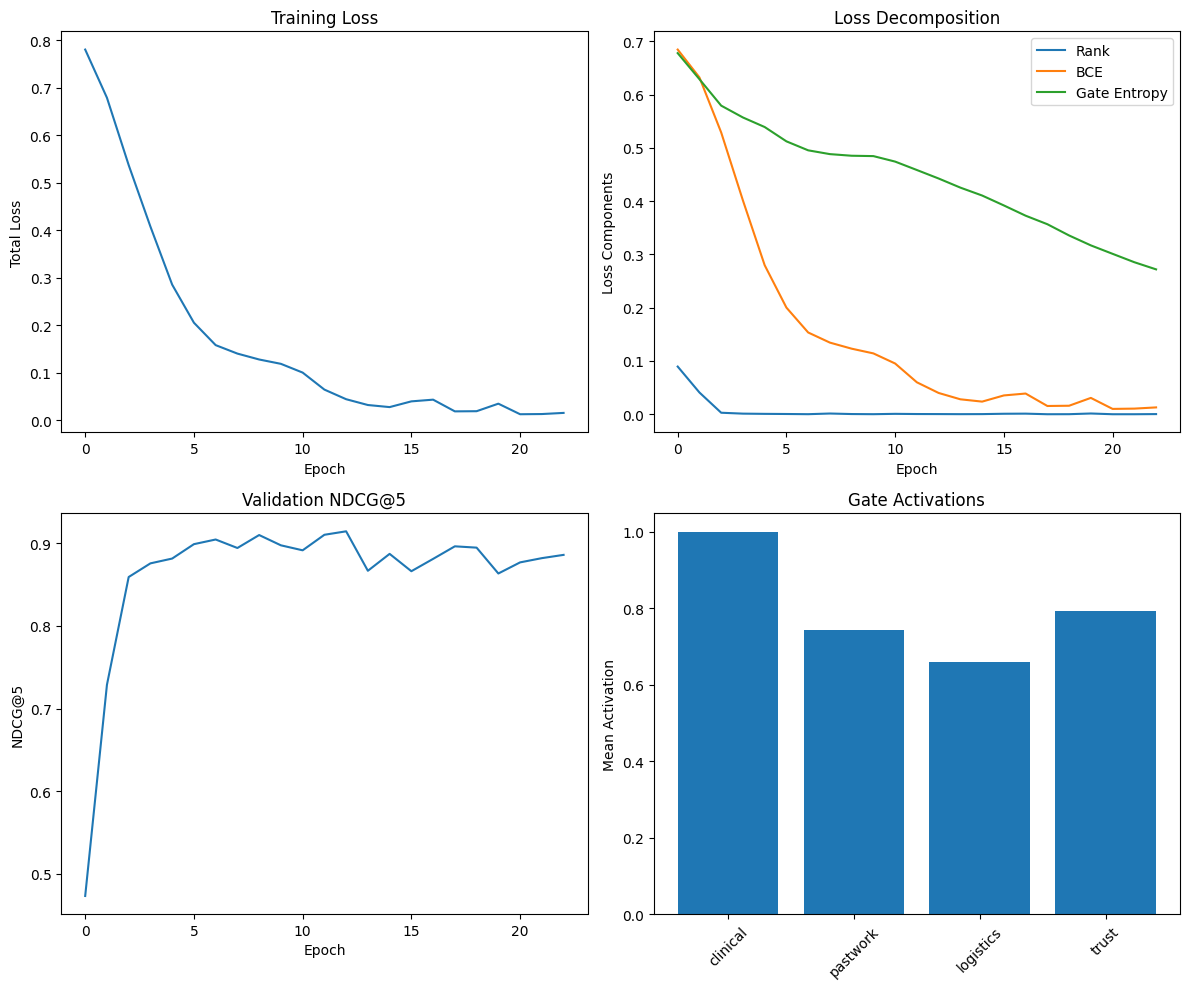


✅ Training complete!


In [9]:
# ============================================================
# CELL 9: Visualizations
# ============================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax = axes[0, 0]
ax.plot(history['train_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Loss')
ax.set_title('Training Loss')

ax = axes[0, 1]
ax.plot(history['rank_loss'], label='Rank')
ax.plot(history['bce_loss'], label='BCE')
ax.plot(history['gate_entropy'], label='Gate Entropy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss Components')
ax.set_title('Loss Decomposition')
ax.legend()

ax = axes[1, 0]
ax.plot(history['val_ndcg5'])
ax.set_xlabel('Epoch')
ax.set_ylabel('NDCG@5')
ax.set_title('Validation NDCG@5')

ax = axes[1, 1]
gates = ['clinical', 'pastwork', 'logistics', 'trust']
x = np.arange(len(gates))
ax.bar(x, [test_gates[g]['mean'] for g in gates])
ax.set_xticks(x)
ax.set_xticklabels(gates, rotation=45)
ax.set_ylabel('Mean Activation')
ax.set_title('Gate Activations')

plt.tight_layout()
plt.savefig(f'{RUN_DIR}/original_seed{SEED}_training_curves.png', dpi=150)
plt.show()

print('\n✅ Training complete!')

In [10]:
# ============================================================
# SANITY CHECKS: Random / MCDA / Strict Threshold Metrics
# ============================================================
import numpy as np
import torch

# Load MCDA if available
MCDA_PATH = f"{DATA_DIR}/mcda_scores.pt"
has_mcda = False
if os.path.exists(MCDA_PATH):
    mcda_scores = torch.load(MCDA_PATH, weights_only=False)
    if torch.is_tensor(mcda_scores):
        mcda_scores = mcda_scores.cpu().numpy()
    has_mcda = True

def ndcg_at_k(scores, labels, k):
    ranking = np.argsort(-scores)[:k]
    dcg = sum((2**labels[r] - 1) / np.log2(i + 2) for i, r in enumerate(ranking))
    ideal = np.argsort(-labels)[:k]
    idcg = sum((2**labels[r] - 1) / np.log2(i + 2) for i, r in enumerate(ideal))
    return dcg / idcg if idcg > 0 else 0.0

def mrr_thr(scores, labels, thr=3):
    ranking = np.argsort(-scores)
    rel = labels >= thr
    for i, idx in enumerate(ranking):
        if rel[idx]:
            return 1.0 / (i + 1)
    return 0.0

def hr_at_k_thr(scores, labels, k=5, thr=3):
    topk = np.argsort(-scores)[:k]
    return float((labels[topk] >= thr).any())

rng = np.random.default_rng(SEED)

model_ndcg5, rand_ndcg5, mcda_ndcg5 = [], [], []
mrr3_list, hr5_3_list = [], []

model.eval()
with torch.no_grad():
    for bi, batch in enumerate(test_loader):
        case_emb = batch['case_embedding'].to(device)
        doc_embs = batch['doctor_embeddings'].squeeze(0).to(device)
        clinical = batch['clinical'].squeeze(0).to(device)
        pastwork = batch['pastwork'].squeeze(0).to(device)
        logistics = batch['logistics'].squeeze(0).to(device)
        trust = batch['trust'].squeeze(0).to(device)
        context = batch['context'].to(device)
        labels = batch['relevance'].squeeze(0).cpu().numpy()

        # Model scores
        s = []
        for i in range(doc_embs.shape[0]):
            out = model(
                case_emb, doc_embs[i:i+1],
                clinical[i:i+1], pastwork[i:i+1],
                logistics[i:i+1], trust[i:i+1],
                context
            )
            s.append(out['score'].item())
        s = np.array(s)

        model_ndcg5.append(ndcg_at_k(s, labels, 5))
        mrr3_list.append(mrr_thr(s, labels, thr=3))
        hr5_3_list.append(hr_at_k_thr(s, labels, k=5, thr=3))

        # Random baseline
        rs = rng.random(len(labels))
        rand_ndcg5.append(ndcg_at_k(rs, labels, 5))

        # MCDA baseline (same case index in test split order)
        if has_mcda:
            case_global_idx = splits['test'][bi]
            ms = mcda_scores[case_global_idx]
            mcda_ndcg5.append(ndcg_at_k(ms, labels, 5))

print("\nSanity Check Results")
print("-" * 50)
print(f"Model NDCG@5:   {np.mean(model_ndcg5):.4f} ± {np.std(model_ndcg5):.4f}")
print(f"Random NDCG@5:  {np.mean(rand_ndcg5):.4f} ± {np.std(rand_ndcg5):.4f}")
if has_mcda:
    print(f"MCDA NDCG@5:    {np.mean(mcda_ndcg5):.4f} ± {np.std(mcda_ndcg5):.4f}")

print("\nStrict-threshold metrics (relevant = label >= 3)")
print(f"MRR@thr3:       {np.mean(mrr3_list):.4f} ± {np.std(mrr3_list):.4f}")
print(f"HR@5@thr3:      {np.mean(hr5_3_list):.4f} ± {np.std(hr5_3_list):.4f}")



Sanity Check Results
--------------------------------------------------
Model NDCG@5:   0.9175 ± 0.1078
Random NDCG@5:  0.3930 ± 0.1621
MCDA NDCG@5:    0.8896 ± 0.1251

Strict-threshold metrics (relevant = label >= 3)
MRR@thr3:       1.0000 ± 0.0000
HR@5@thr3:      1.0000 ± 0.0000
